# Youtube Chatbot

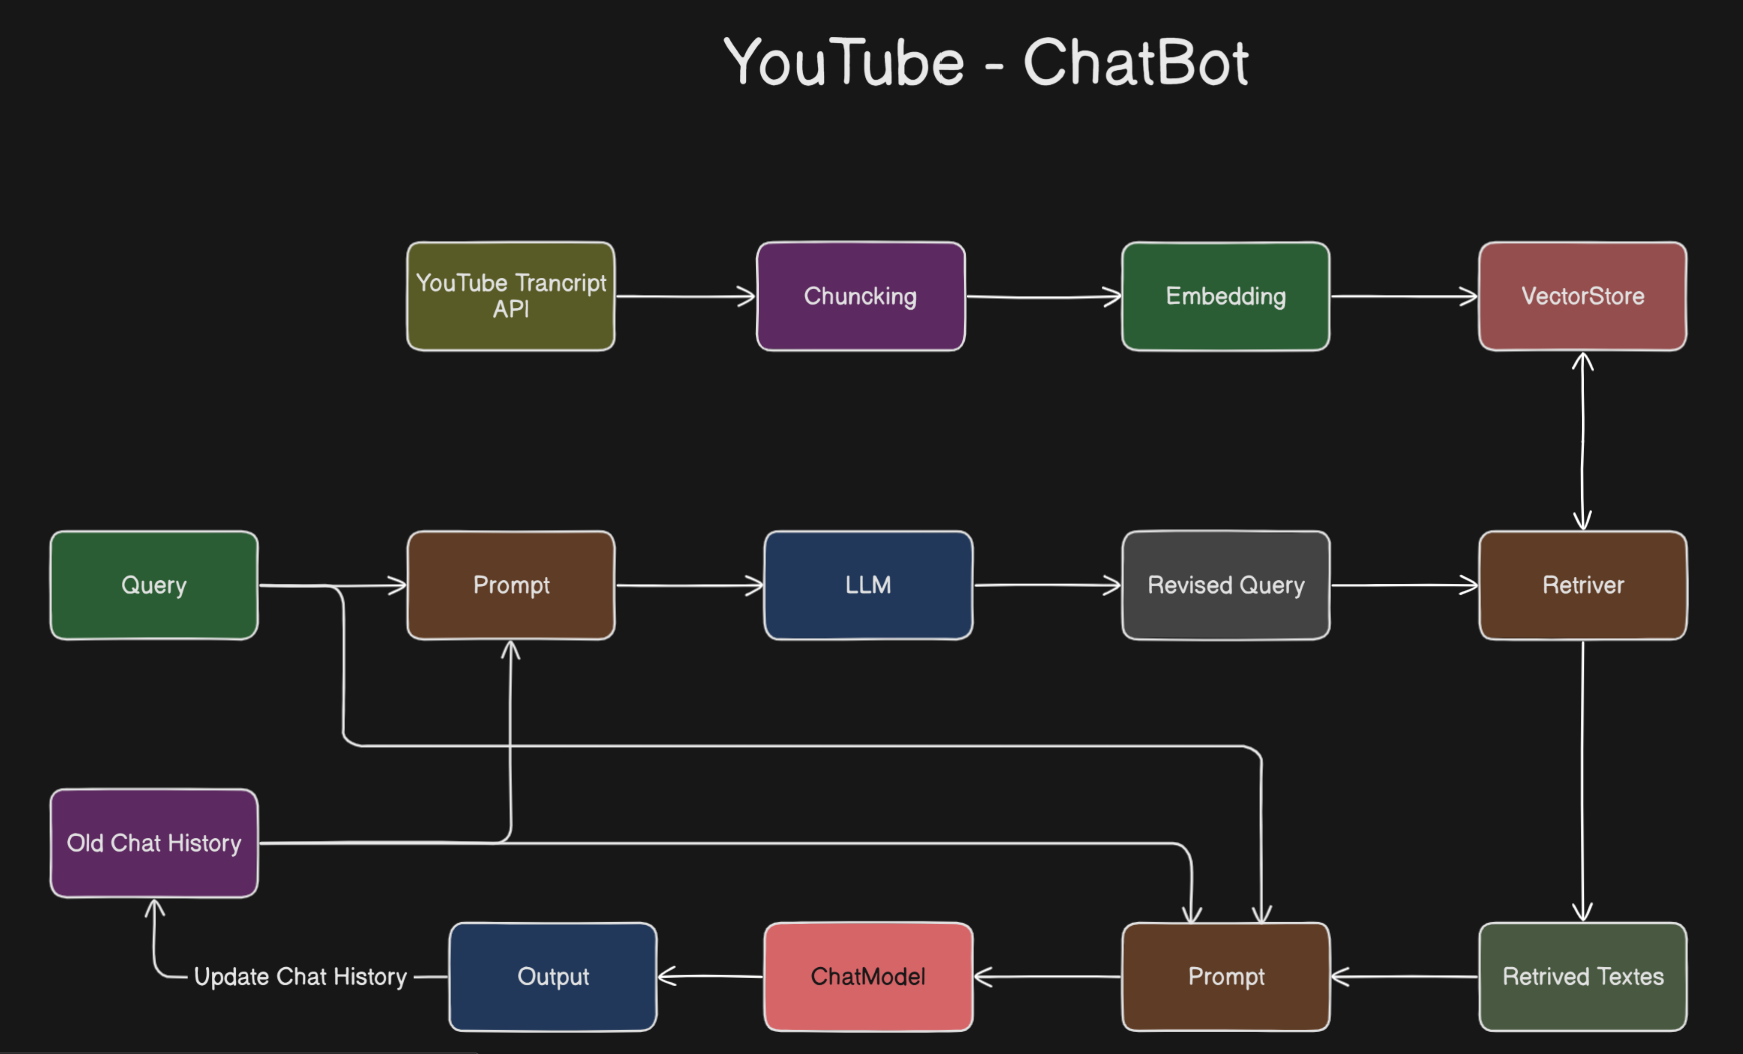

In [1]:
from youtube_transcript_api import YouTubeTranscriptApi, TranscriptsDisabled

In [2]:
Video_link = 'https://www.youtube.com/watch?v=pBRSZBtirAk&ab_channel=JayShettyPodcast'
VideoId = "pBRSZBtirAk"

In [3]:
try:
    transcript_chunk = YouTubeTranscriptApi.get_transcript(video_id=VideoId,languages=["en","hi"])

    transcript =  "".join(chunk["text"] for chunk in transcript_chunk)

except TranscriptsDisabled:
    print("No captions available for this video.")

In [4]:
# Chunking - 
from langchain.text_splitter import RecursiveCharacterTextSplitter
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.create_documents([transcript])

In [5]:
# Create Embedding and VectorStore
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma

Embedding_model = OpenAIEmbeddings(model="text-embedding-3-large")

vector_db = Chroma(collection_name="youtube-transcript",
                   persist_directory="chroma-db",
                   embedding_function=Embedding_model
                   )

C:\Users\tuhin\AppData\Local\Temp\ipykernel_8476\936094679.py:7: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_db = Chroma(collection_name="youtube-transcript",


In [6]:
vector_db.add_documents(chunks)

['8072e1c4-716c-408a-9c59-a487a5850050',
 '6932194e-f2b7-4da4-ac1d-4158ca9b63c2',
 'e2d6d403-6dad-4e4a-9f85-e894270fe0c8',
 'dd027ca1-0d92-43aa-be67-53fe45155b5d',
 'f94e6d24-19be-4059-94b1-36ae00bf751b',
 '1fc3cf40-812d-4b92-a0a2-bbf873142536',
 '9dbc4778-1fda-4cd4-819b-a7b82ff46a8f',
 'c99c66e5-d743-49f4-b383-8e79aa5d076d',
 'e7f5b340-4922-4fe4-a01c-226d2eb90188',
 '9e8b0aa1-4cfd-4334-8c02-11c0d6e5589e',
 'c1e1592d-7350-4828-9a34-cf9677275370',
 'b59077e4-d0f9-48b8-818b-cd9cdfe741c2',
 '32d1bf31-6949-4332-9f44-8d4c5180a64c',
 'e88dee87-4bc3-4ac2-8eb6-cfeae33752ee',
 'b46de414-3d38-40d5-9608-cacf23288e13',
 'a80ef8d0-1f29-45b6-89ef-09d6718f68b1',
 'b3406ccd-2586-4632-8cc3-c16df6d440f6',
 '25c49480-ab61-4f59-996b-9a49d0c379d3',
 '242e46f7-7ef6-4f9e-8ce8-4061695d4bba',
 '70bf8799-6cea-4a11-bb50-1ddeaa0aba1b',
 'a55c587e-a7d9-4b21-b8de-c2ef1b2eaa93',
 '01153ac7-93df-4f1d-9bae-2c9771f5f0a3',
 'bf3c8a95-4dc3-49e0-8dc4-f294ee39f264',
 'd0d258f3-8a0a-4574-8c0e-4a5094653c3b',
 '170cbbfe-d609-

In [7]:
# retriver

retriver = vector_db.as_retriever(search_type='mmr',
                                    kwargs={'k':5,'lambda_mult':0.5})

In [8]:
retrived_document=retriver.invoke("What this video is telling about?")

In [9]:
retrived_text="".join(docs.page_content for docs in retrived_document)

In [10]:
retrived_text

"marriedcreating deeper friendships or focusingon your own Journey therapy can guideyou toward relationships that pourpositivity back into your life that'swhere better help comes in it's fullyonline making therapy convenient andaffordable with over 5 million peoplealready using it worldwide you'll haveaccess to a diverse network of more than30,000 credential therapists with a widerange of Specialties and if your firstmatch isn't the right fit you can switchtherapists anytime at no extra costdiscover your relationship green flagswith better help visit betterhelp.comchop3 to get 10% off your first monththat's better helphp.com jsop 3 what are we getting wrongbecause it sounds like you felt maybethe computer would give people thatimpetus and the ability to download moreand learn more where have we gone wrongwell the key is is motivation if youhave a kid who's super motivated thenyes going to the con website and doingyou know hours of math problems that'sgreat but in a way that takes theor

In [11]:
from langchain.prompts import PromptTemplate
prompt=PromptTemplate(template='''You are a helpful asistant, please answer the given question from provided document
                      question = {query}
                      document = {text}''',
                      input_variables=["query","text"])

In [12]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
model = ChatOpenAI()

chain = prompt | model | StrOutputParser()

In [13]:
output=chain.invoke({"query":"What this video is telling about?",
             "text":retrived_text})

In [14]:
output

"The video is about the benefits of therapy for improving relationships and overall positivity in one's life. It mentions a convenient and affordable online therapy platform called BetterHelp, which connects users with a diverse network of over 30,000 therapists. The video also delves into a conversation about motivation in education and the impact of technology on society."

# Chatbot Chain With Memory

In [15]:
from langchain_core.prompts import ChatPromptTemplate

In [16]:
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question "
    "If you don't know the answer, say that you don't know."
    "Use three sentences maximum and keep the answer concise."
    "\n\n"
    "{context}"
)
  

chat_prompt = ChatPromptTemplate(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

In [17]:
from langchain.chains.retrieval import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_openai import ChatOpenAI


In [18]:

question_answering_chain = create_stuff_documents_chain(llm=model,prompt=chat_prompt)

In [19]:
rag_chain = create_retrieval_chain(retriver,question_answering_chain)

In [20]:
response=rag_chain.invoke({"input":"Who is the woner of microshoft?"})

In [21]:
response["answer"]

'The owner of Microsoft is Bill Gates.'

In [22]:
from langchain.chains.history_aware_retriever import create_history_aware_retriever
from langchain.prompts import MessagesPlaceholder

In [23]:
retriever_prompt = (
    "Given a chat history and the latest user question which might reference context in the chat history,"
    "formulate a standalone question which can be understood without the chat history."
    "Do NOT answer the question, just reformulate it if needed and otherwise return it as is."
)

contextualize_q_prompt  = ChatPromptTemplate(
    [
        ("system", retriever_prompt),
        MessagesPlaceholder(variable_name="chat_history"),
        ("human", "{input}"),
     ]
)

In [24]:
from langchain_core.messages import HumanMessage, AIMessage
# chat_history = [{"human":"what is 2+2","system":"2+2 is 4"}]

chat_history = [[
        HumanMessage(content="what is 2+2"),
        AIMessage(content="2+2 is 4"),
    ]]

In [25]:
history_aware_retriever = create_history_aware_retriever(model,retriver,contextualize_q_prompt)

In [26]:
qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

In [27]:
question_answer_chain = create_stuff_documents_chain(model, qa_prompt)

In [28]:
rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)

In [3]:
# rqvised_q = rag_chain.invoke({"input": "What will be the multiplication of this 2 number?", "chat_history": chat_history})